In [1]:
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
from math import sqrt

eps = np.finfo(float).eps

# 高斯滤波

## 高斯高通滤波GaussianHPF

频率域高斯高通滤波公式如下，注意公式$D$和$D_0$的区别

$$H(u,v) = 1-e^{\dfrac{-D^2(u,v)}{2D_0^2}}$$

## 高斯低通滤波GaussianLPF

频率域高斯低通滤波公式如下

$$H(u,v) = e^{\dfrac{-D^2(u,v)}{2D_0^2}}$$

In [2]:
def getGaussianMask(mask_shape,filter_d0,hl_type):
    assert hl_type in ("lpf","hpf")
    rows,cols = mask_shape[0],mask_shape[1]
    crow = rows/2
    ccol = cols/2
    mask = np.zeros((rows,cols))
    for i in range(rows):
        for j in range(cols):
            dis = sqrt((i-crow)**2 + (j-ccol)**2)
            if hl_type == "hpf":  
                mask[i,j] = 1-np.exp(-(dis**2) / (2*(filter_d0**2)))
            elif hl_type == "lpf":
                mask[i,j] = np.exp(-(dis**2)/(2*(filter_d0**2)))
    return mask

def getGaussianFilterPassImg(input_img : np.array, filter_type : str , filter_d0  , size = None):
    assert filter_type in ("lpf","hpf")
    f_img = np.fft.fft2(input_img , s = size)
    shift_img = np.fft.fftshift(f_img)
    mask_shift_img = getGaussianMask(f_img.shape,filter_d0,filter_type)
    new_shift_img = mask_shift_img*shift_img
    new_manitude_img = 20*np.log(np.abs(new_shift_img+eps))
    new_f_img = np.fft.ifftshift(new_shift_img)
    new_img = np.fft.ifft2(new_f_img)
    new_img = np.abs(new_img)
    return new_img,new_manitude_img,mask_shift_img

# DFT固有周期测试



实现方法，由于numpy.fft.fft2方法参数中可以指定输出图像的大小，官方描述如下：

> s : sequence of ints, optional
>
> _Shape (length of each transformed axis) of the output (s[0] refers to axis 0, s[1] to axis 1, etc.). This corresponds to n for fft(x, n). Along each axis, if the given shape is smaller than that of the input, the input is cropped. If it is larger, the input is padded with zeros. if s is not given, the shape of the input along the axes specified by axes is used._

该参数默认为DFT变换后大小为原图大小，若指定输出大小大于原图大小，则进行0填充，我们可以利用该参数实现我们的测试。

## 不经裁剪

直接以s的默认值（None）调用numpy.fft.fft2实际上就是进行的非0填充

调用我之前写的方法，实现如下

```python
lpf_cycle_img, manitude_cycle_img,mask_img = getGaussianFilterPassImg(cycle_img , "lpf" , 5 )
```

或者如下

```python
lpf_cycle_img, manitude_cycle_img,mask_img = getGaussianFilterPassImg(cycle_img , "lpf" , 5 ,size = None)
```

## 进行裁剪

根据教材P157解释以及P159、P163页，二维零填充避免缠绕错误的结论与一维相同，令$f(x)$和$h(x)$分别是大小为$A \times B$和$C \times D$像素的图像阵列。循环卷积中的缠绕错误可以通过下面函数进行零填充来避免，方法如下：

$$ f_p(x,y)=\left \{
\begin{aligned}
f(x,y)  & , &  0 \le x \le A-1 和  0 \le y\le B-1 \\
0 & , & A \le x \le P 或 B \le y \le Q
\end{aligned}
\right. $$

和

$$ h_p(x,y)=\left \{
\begin{aligned}
h(x,y)  & , &  0 \le x \le C-1 和  0 \le y\le D-1 \\
0 & , & C \le x \le P 或 D \le y \le Q
\end{aligned}
\right. $$

其中，

$$ P \ge A+C -1 $$

和

$$ Q \ge B+D-1 $$





那么实现方法就有两种：

1. 通过其他方法进行补0后调用s为None的DFT
2. 通过调整s为(P,Q)大小调用DFT

填充的代码实现：


In [3]:
def getPaddingSize(shape1,shape2):
    return shape1[0]+shape2[0]-1,shape1[1]+shape2[1]-1

def getPaddingImg(fimg,himg_shape, position = "corner"):
    fimg = np.array(fimg)
    himg = np.array(himg_shape)
    assert position in ("corner","middle")
    fimg = np.array(fimg)
    rows,cols = fimg.shape
    prows,pcols = getPaddingSize(fimg.shape,himg_shape)
    if position == "corner":
        new_img = np.pad(fimg,((0,prows-rows),(0,pcols-cols)),'constant', constant_values = 0)
    else:
        cal = lambda x,y: ((x-y)//2 , x-y-(x-y)//2)
        
        new_img = np.pad(fimg,(cal(prows,rows),cal(pcols,cols)),'constant', constant_values = 0)
    return new_img

def cutOriginalImg(pad_img,originalsize,position = "corner"):
    assert position in ("corner","middle")
    if(position == "corner"):
        return pad_img[0:originalsize[0],0:originalsize[1]]
    else:
        padsizer = pad_img.shape[0]-originalsize[0]
        padsizec = pad_img.shape[1]-originalsize[1]
        return pad_img[padsizer//2:padsizer//2+originalsize[0],padsizec//2:padsizec//2+originalsize[1]]

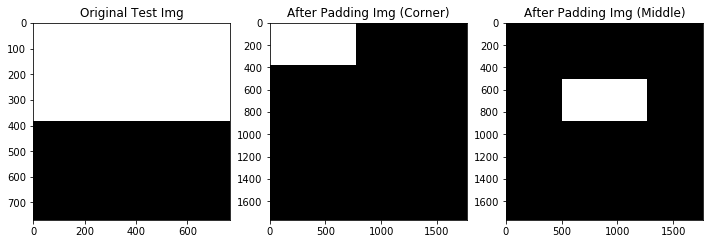

In [4]:
cycle_img = cv2.imread('./DIP3E_Original_Images_CH04/Fig0432(a)(square_original).tif',0)
cycle_img_corner = getPaddingImg(cycle_img,(1000,1000),position = "corner")
cycle_img_middle = getPaddingImg(cycle_img,(1000,1000),position = "middle")
plt.figure(figsize=(12,8))
ax1 = plt.subplot(131)
ax1.imshow(cycle_img, cmap = "gray")
ax1.set_title("Original Test Img")
ax2 = plt.subplot(132)
ax2.imshow(cycle_img_corner, cmap = "gray")
ax2.set_title("After Padding Img (Corner)")
ax3 = plt.subplot(133)
ax3.imshow(cycle_img_middle, cmap = "gray" )
ax3.set_title("After Padding Img (Middle)")
plt.show()

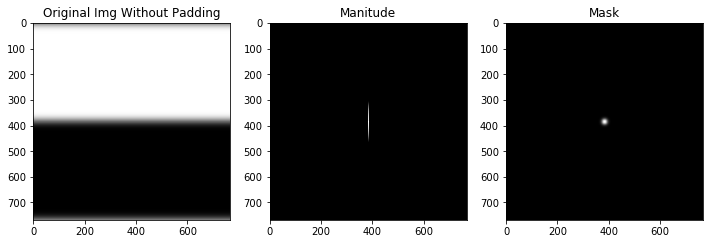

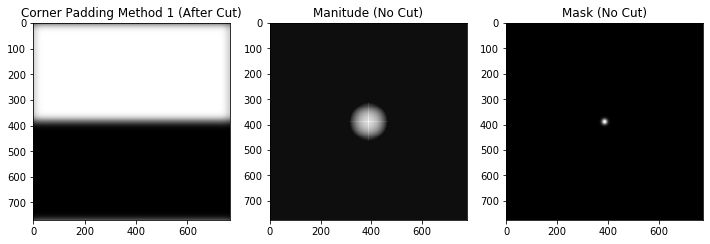

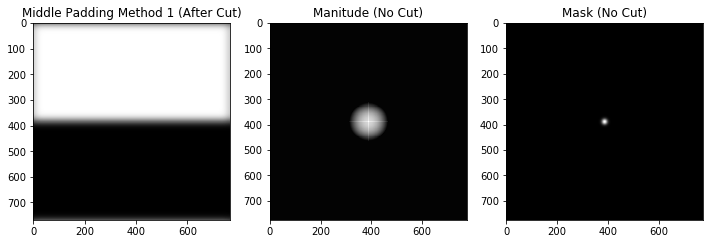

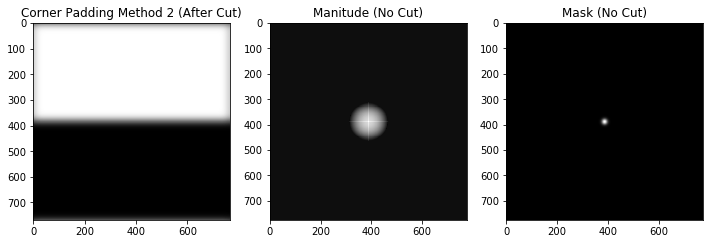

In [5]:
def showThreeImg(img1,img2,img3,img_name1 = None,img_name2 = None,img_name3 = None):
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(131)
    ax1.set_title(img_name1)
    ax1.imshow(img1  , cmap = "gray")
    ax2 = plt.subplot(132)
    ax2.imshow(img2, cmap = "gray")
    ax2.set_title(img_name2)
    ax3 = plt.subplot(133)
    ax3.imshow(img3,cmap = "gray")
    ax3.set_title(img_name3)
    plt.show()


mfilter_size = 8
# 先构建mask

# 尝试方法零（不填充）
# 通过自编写方法补零后再进行DFT加高斯低通滤波
lpf_cycle_img_nopadding, manitude_cycle_img,mask_img = getGaussianFilterPassImg(cycle_img , "lpf" , mfilter_size)
showThreeImg(lpf_cycle_img_nopadding,manitude_cycle_img,mask_img,"Original Img Without Padding","Manitude","Mask")
# 尝试方法1 （预填充）
## Corner
pad_cycle_img_corner = getPaddingImg(cycle_img,(mfilter_size,mfilter_size),"corner")
lpf_cycle_img_padcorner_m1, manitude_cycle_img,mask_img = getGaussianFilterPassImg(pad_cycle_img_corner , "lpf" , mfilter_size)
cut_lpf_cycle_img_padcorner_m1 = cutOriginalImg(lpf_cycle_img_padcorner_m1,cycle_img.shape,"corner")
showThreeImg(cut_lpf_cycle_img_padcorner_m1,manitude_cycle_img,mask_img,"Corner Padding Method 1 (After Cut)","Manitude (No Cut)","Mask (No Cut)")

## Middle
pad_cycle_img_middle = getPaddingImg(cycle_img,(mfilter_size,mfilter_size),"middle")
lpf_cycle_img_padmiddle_m1, manitude_cycle_img,mask_img = getGaussianFilterPassImg(pad_cycle_img_middle , "lpf" , mfilter_size)
cut_lpf_cycle_img_padmiddle_m1 = cutOriginalImg(lpf_cycle_img_padmiddle_m1,cycle_img.shape,"middle")
showThreeImg(cut_lpf_cycle_img_padmiddle_m1,manitude_cycle_img,mask_img,"Middle Padding Method 1 (After Cut)","Manitude (No Cut)","Mask (No Cut)")

# 尝试方法2 （限定s自动零填充）
## 实现了相同的效果
lpf_cycle_img_padcorner_m2, manitude_cycle_img,mask_img = getGaussianFilterPassImg(cycle_img , "lpf" , mfilter_size , size = getPaddingSize(cycle_img.shape,np.array([mfilter_size,mfilter_size])))
cut_lpf_cycle_img_padcorner_m2 = cutOriginalImg(lpf_cycle_img_padcorner_m2,cycle_img.shape,"corner")
showThreeImg(cut_lpf_cycle_img_padcorner_m2,manitude_cycle_img,mask_img,"Corner Padding Method 2 (After Cut)","Manitude (No Cut)","Mask (No Cut)")


In [6]:
print(lpf_cycle_img_padmiddle_m1.shape)
print(cut_lpf_cycle_img_padmiddle_m1.shape)
print("Really Cut")

print((cut_lpf_cycle_img_padcorner_m1==cut_lpf_cycle_img_padcorner_m2).all())
print("Method 2 has the same effect as Method 1 and generalize the same img.")

(775, 775)
(768, 768)
Really Cut
True
Method 2 has the same effect as Method 1 and generalize the same img.


上述实验证明了DFT固有周期带来的一些影响，未进行零填充的Original Img由于固有周期亮色部分左右仍旧是亮色部分，所以使滤波器丧失了能力，在一些情况下我们希望避免这种固有周期带来的影响，因而才引入了零填充的方式。

正如课本P163以及P164所讲：

> 用0填充图像后，在周期序列的周围建立了一个平坦的边界。

> 从这个例子可以看到，错误地填充一幅图像会导致错误的结果。

当然，这种错误只存在于“ 边界”

> 如果滤波的目的仅是粗糙的视觉分析，那么有时可以跳过填充步骤。

根据两种方式Padding得到的最终裁减后图像的比较（All True），也证明了我使用的两种方法，Method 1：手动填充0金和Method 2：利用`numpy.fft.fft2()`中自动0填充的方式确实都得到了相同的结果。